In [151]:
%matplotlib inline

In [165]:
# Setting up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import create_engine, inspect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn as skl
import ast

from config import user, password, hostname

# Preprocessing
### In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors. 

### Connecting to database

In [183]:
# Create engine
engine = create_engine(f'postgres://{user}:{password}@{hostname}/twitter_vs_stocks')

# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['stock', 'tweets_text', 'twitter_vs_stocks']

In [184]:
# Create dataframe from SQL table
twitter_vs_stocks = pd.read_sql_table(
    'twitter_vs_stocks',
    con=engine)
twitter_vs_stocks.set_index(['date'], inplace=True)
twitter_vs_stocks.rename({'volume': 'volume_traded'}, axis=1, inplace=True)
twitter_vs_stocks.head()

,tokenized_text,like_count,quote_count,reply_count,retweet_count,volume_traded,change
date,,,,,,,
2020-06-19,"['juneteenth', 'henceforth', 'considered', 'ho...",402800,2590,5884,31264,43398500,-0.612015
2020-06-22,"['tentative', 'date', 'tesla', 'shareholder', ...",133516,892,5246,5438,31812000,-1.315994
2020-06-25,"['gerberkawasaki', 'first', 'thoughts', 'drivi...",259296,1039,4758,10802,46272500,5.026001
2020-06-26,"['jeffbezos', 'copy', 'controls', 'memes', 'co...",2248367,24436,32923,300062,44274500,-5.248001
2020-06-30,"['gps', 'got', 'slightly', 'better', 'spacex',...",156800,688,2610,21575,84592500,14.092010


### Defining the most common words in tweets

In [185]:
# define function for counting words
def count_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [186]:
# count words in tweets
words_in_tweets = count_words(twitter_vs_stocks.tokenized_text)
words_in_tweets[:30]

[('spacex', 115),
 ('tesla', 82),
 ('falcon', 42),
 ('launch', 40),
 ('first', 32),
 ('dragon', 27),
 ('model', 21),
 ('mission', 21),
 ('starship', 20),
 ('crew', 20),
 ('flight', 18),
 ('space_station', 17),
 ('landing', 17),
 ('starlink', 16),
 ('stage', 15),
 ('doo', 15),
 ('giga', 14),
 ('people', 14),
 ('nasa', 14),
 ('next', 14),
 ('orbit', 13),
 ('doge', 13),
 ('make', 12),
 ('go', 12),
 ('test', 12),
 ('confirmed', 12),
 ('satellites', 12),
 ('new', 11),
 ('today', 11),
 ('going', 11)]

In [188]:
# analyse only words that appear 3 or more times
words_to_analyse = [word for word, freq in words_in_tweets if freq >= 3]
words_to_analyse[:10]

['spacex',
 'tesla',
 'falcon',
 'launch',
 'first',
 'dragon',
 'model',
 'mission',
 'starship',
 'crew']

In [189]:
len(words_to_analyse)

301

### Count words in tweets

In [190]:
# convert text rows from string to list 
twitter_vs_stocks.tokenized_text = [ast.literal_eval(row) for row in twitter_vs_stocks.tokenized_text]

In [191]:
# count words in the tokenized text (tweets)
for column in words_to_analyse:
    count_list = []
    for row in np.arange(0,len(twitter_vs_stocks.tokenized_text)):
         count_list.append(twitter_vs_stocks.tokenized_text[row].count(column))
    twitter_vs_stocks[column] = count_list

In [192]:
twitter_vs_stocks.head()

,tokenized_text,like_count,quote_count,reply_count,retweet_count,volume_traded,change,spacex,tesla,falcon,...,happy,house,window,opens,road,monkey,utility,nbcsnl,promising,event
date,,,,,,,,,,,,,,,,,,,,,
2020-06-19,"[juneteenth, henceforth, considered, holiday, ...",402800,2590,5884,31264,43398500,-0.612015,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-22,"[tentative, date, tesla, shareholder, meeting,...",133516,892,5246,5438,31812000,-1.315994,0,4,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-25,"[gerberkawasaki, first, thoughts, driving, new...",259296,1039,4758,10802,46272500,5.026001,0,5,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-26,"[jeffbezos, copy, controls, memes, controls, u...",2248367,24436,32923,300062,44274500,-5.248001,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-30,"[gps, got, slightly, better, spacex, falcon, f...",156800,688,2610,21575,84592500,14.092010,2,1,1,...,0,0,0,0,0,0,0,0,0,0


### Scaling and Features Extraction

In [193]:
X = twitter_vs_stocks.drop(columns=['tokenized_text', 'change', 'volume_traded'])
y_change = twitter_vs_stocks.change
y_volume = twitter_vs_stocks.volume

In [199]:
X.co

,like_count,quote_count,reply_count,retweet_count,spacex,tesla,falcon,launch,first,dragon,...,happy,house,window,opens,road,monkey,utility,nbcsnl,promising,event
date,,,,,,,,,,,,,,,,,,,,,
2020-06-19,402800,2590,5884,31264,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-22,133516,892,5246,5438,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-25,259296,1039,4758,10802,0,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-26,2248367,24436,32923,300062,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-30,156800,688,2610,21575,2,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-07,309350,2645,13721,24726,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-08,634606,3304,38616,37561,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-09,311504,2772,19282,27065,1,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Tagret is Change

In [200]:
# Split dataset to training and testing
X_train, X_test, y_change_train, y_change_test = train_test_split(X, y_change, random_state=12)

In [201]:
# Create scaler instance
scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [205]:
len(X_test_scaled[0])

305

Text(0, 0.5, 'cumulative explained variance')

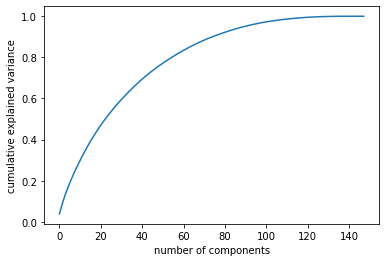

In [203]:
# choose number of components for PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#### we need at least 100 components to describe 90% of the variance

In [209]:
# Reduce the number of components in X to 150 using PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#### Tagret is Volume Traded

In [210]:
# Split dataset to training and testing
X_train, X_test, y_volume_train, y_volume_test = train_test_split(X, y_volume, random_state=10)

In [211]:
scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

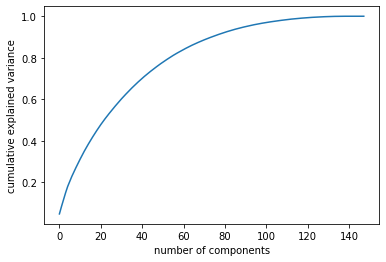

In [212]:
# choose number of components for PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [214]:
# Reduce the number of components in X to 10 using PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# ML Model